In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy import linalg
import pdb
%matplotlib inline

def generate_data():
    theta = np.random.uniform(0, 2*np.pi, 100)
    w1, w2 = np.random.normal(0, 1, 100), np.random.normal(0, 1, 100)
    first_x1, first_x2 = 8*np.cos(theta) + w1, 8*np.sin(theta) + w2
    second_x1, second_x2 = np.random.normal(0, 1, 100), np.random.normal(0, 1, 100)
    data = np.r_[np.c_[first_x1, first_x2, np.ones(100)], np.c_[second_x1, second_x2, -1*np.ones(100)]]
    np.random.shuffle(data)
    X, y = data[:,:2], data[:,2]
    return X, y

def plot(X, y):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    x1 = X[:,0]
    x2 = X[:,1]
    rgb = plt.get_cmap('jet')(y)
    ax.scatter(x1, x2, color=rgb)
    plt.show()
    # plt.savefig('/tmp/out.png')    # to save the figure to a file

def split_dataset(data, size=50000):
    return data[:size], data[size:]

def kernelize_poly(x, z, p=2):
    return np.power(x.T.dot(z) + 1, p)

def kernelize_gauss(x, z, gamma=10):
    return np.exp(-gamma*(x-z).T.dot(x-z))

def train(X_train, y_train, reg=0, kernelize=kernelize_poly):
    ''' Build a model from X_train -> y_train '''
    K = np.zeros((X_train.shape[0], X_train.shape[0]))
    for i in range(X_train.shape[0]):
        for j in range(X_train.shape[0]):
            K[i][j] = kernelize(X_train[i], X_train[j])
    return linalg.solve(K + reg*np.eye(K.shape[0]), y_train, sym_pos=True)

def predict(model, X_train, X_test, kernelize=kernelize_poly):
    ''' From model and data points, output prediction vectors '''
    pred = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
        h = 0
        for j in range(X_train.shape[0]):
            h += model[j]*kernelize(X_train[j], X_test[i])
        pred[i] = h
    return np.where(pred>0.0, 1.0, -1.0)

def plot_contour(X_train, y_train, kernelize=kernelize_poly, reg=1e-6, h=0.1, title='polynomial kernel'):
    model = train(X_train, y_train, reg, kernelize)
    x_min, x_max = X_train[:,0].min() - 1, X_train[:,0].max() + 1
    y_min, y_max = X_train[:,1].min() - 1, X_train[:,1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    pred_grid = predict(model, X_train, grid, kernelize).reshape(xx.shape)

    plt.contourf(xx, yy, pred_grid, cmap=plt.cm.Paired)
    plt.axis('off')
    plt.title('Decision boundary with ' + title)

    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.Paired)

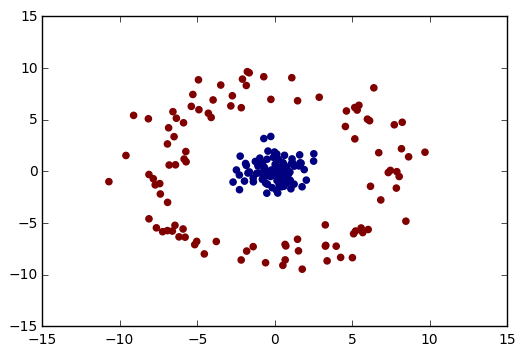

Train accuracy: 0.995
Test accuracy: 0.995
Train accuracy: 1.0
Test accuracy: 1.0


In [6]:
X, y = generate_data()
X_train, y_train = X, y#X[:-50], y[:-50]
X_test, y_test = X, y#X[-50:], y[-50:]

plot(X, y)

model_poly = train(X_train, y_train, 1e-6)
pred_poly_train = predict(model_poly, X_train, X_train)
pred_poly_test = predict(model_poly, X_train, X_test)

model_gauss = train(X_train, y_train, reg=1e-4, kernelize=kernelize_gauss)
pred_gauss_train = predict(model_gauss, X_train, X_train, kernelize=kernelize_gauss)
pred_gauss_test = predict(model_gauss, X_train, X_test, kernelize=kernelize_gauss)

print("Train accuracy: {0}".format(metrics.accuracy_score(y_train, pred_poly_train)))
print("Test accuracy: {0}".format(metrics.accuracy_score(y_test, pred_poly_test)))

print("Train accuracy: {0}".format(metrics.accuracy_score(y_train, pred_gauss_train)))
print("Test accuracy: {0}".format(metrics.accuracy_score(y_test, pred_gauss_test)))

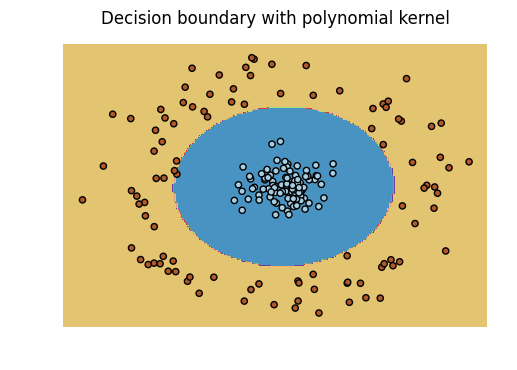

In [7]:
# Polynomial Kernel with reg=1e-6
plot_contour(X_train, y_train)

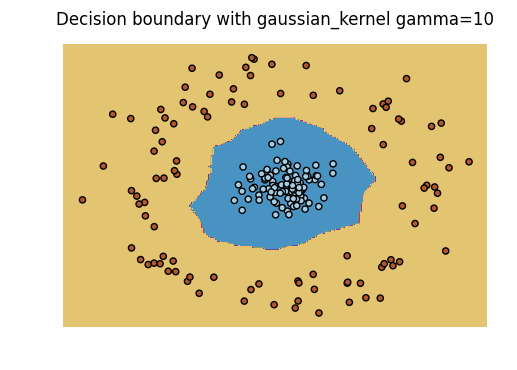

In [19]:
# Gaussian Kernel with reg=1e-4, gamma=10
plot_contour(X_train, y_train, kernelize=kernelize_gauss, reg=1e-4, title='gaussian_kernel gamma=10')

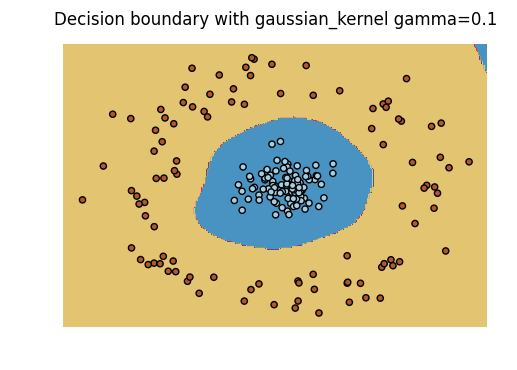

In [20]:
# Gaussian Kernel with reg=1e-4, gamma=0.1
kernelize_gauss_1 = lambda x,z: kernelize_gauss(x, z, gamma=0.1)
plot_contour(X_train, y_train, kernelize=kernelize_gauss_1, reg=1e-4, title='gaussian_kernel gamma=0.1')

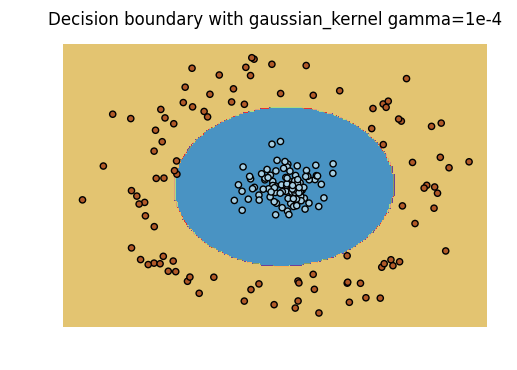

In [21]:
# Gaussian Kernel with reg=1e-4, gamma=1e-4
kernelize_gauss_2 = lambda x,z: kernelize_gauss(x, z, gamma=1e-4)
plot_contour(X_train, y_train, kernelize=kernelize_gauss_2, reg=1e-4, title='gaussian_kernel gamma=1e-4')

In [ ]:
import numpy as np
import scipy.stats
import scipy.io
import sklearn.metrics as metrics
import pdb
import pandas as pd
import sys
import csv
import math
import random

class RandomForest:
    def __init__(self, size=10, depth=6, subset=0.4):
        self.size = size
        self.depth = depth
        self.subset = subset
        self.trees = []

    def train(self, train_data, train_labels, categorical=[], bag_attributes=True):
        for i in range(self.size):
            print("Training tree: ", i)
            data = np.c_[train_data, train_labels]
            rows = random.sample(range(data.shape[0]), int(self.subset*data.shape[0]))
            tree = DecisionTree(self.depth, bag_attributes)
            tree.train(data[rows][:,:-1], data[rows][:,-1], categorical)
            if i%50 == 0:
                print(tree)
            self.trees.append(tree)
        return self.trees

    def predict(self, test_data):
        pred = np.zeros(test_data.shape[0])
        for i, tree in enumerate(self.trees):
            print("Predicting from tree: ", i)
            pred += tree.predict(test_data)
        return np.round(pred/self.size)

class DecisionTree:
    def __init__(self, depth=10, bag_attributes=False):
        self.root = Node()
        self.depth = depth
        self.bag_attributes = bag_attributes

    def entropy(self, hist):
        if np.count_nonzero(hist) < 2:
            return 0
        prob = hist/np.sum(hist)
        return -(prob).dot(np.log2(prob))

    def impurity(self, left_label_hist, right_label_hist):
        left_entropy, left_tot = self.entropy(left_label_hist), np.sum(left_label_hist)
        right_entropy, right_tot = self.entropy(right_label_hist), np.sum(right_label_hist)
        return (left_entropy*left_tot + right_entropy*right_tot)/(left_tot+right_tot)

    def counter(self, combined):
        sort = combined[np.argsort(combined[:,0])]
        freq = np.array([int(sort[0][0]), 0, 0]).reshape((1, 3))
        for i in range(sort.shape[0]):
            val = int(sort[i][0])
            label = int(sort[i][1])
            if val != freq[-1][0]:
                freq = np.r_[freq, np.array([val, 0, 0]).reshape((1, 3))]
            freq[-1][label+1] += 1
        return freq

    def segmenter(self, data, labels, categorical):
        ''' Finds split rule (feature and threshold) with lowest impurity '''
        split_rule = (0, 0, '')
        min_impurity = sys.maxsize

        if self.bag_attributes:
            subset = random.sample(range(data.shape[1]), int(np.sqrt(data.shape[1])))
        else:
            subset = np.arange(data.shape[1])
        data = data[:,subset]
        for i, col in enumerate(data.T):
            freq = self.counter(np.c_[col, labels])
            if i in categorical:
                for j, row in enumerate(freq):
                    in_set = freq[j,1:]
                    not_in_set = np.sum(freq[:j,1:], axis=0) + np.sum(freq[j+1:,1:],axis=0)
                    imp = self.impurity(in_set, not_in_set)
                    if imp < min_impurity:
                        min_impurity = imp
                        split_rule = (subset[i], row[0], 'categorical')
            else:
                for j, row in enumerate(freq):
                    left = np.sum(freq[:j,1:], axis=0)
                    right = np.sum(freq[j:,1:], axis=0)
                    imp = self.impurity(left, right)
                    if imp < min_impurity:
                        min_impurity = imp
                        split_rule = (subset[i], row[0], 'numerical') # (feature i, threshold_value row[0]) [can add left in to indicate index of split]
        return split_rule

    def train(self, train_data, train_labels, categorical=[]):
        ''' Grows decision tree to find best splits of input data '''
        def trainer(train_data, train_labels, depth):
            node = Node()
            if depth == 0:
                node.label = np.round(np.sum(train_labels)/train_labels.shape[0])
                return node

            feature, threshold, var_type = self.segmenter(train_data, train_labels, categorical)

            data = np.c_[train_data, train_labels]
            sort = data[np.argsort(data[:,feature])]
            threshold_ind = np.where(sort[:,feature]==threshold)[0] #if too slow, can return index from segmenter

            if threshold_ind[0] == 0:
                node.label = np.round(np.sum(train_labels)/train_labels.shape[0])
                return node
            if var_type == 'categorical':
                left_data = sort[threshold_ind[0]:threshold_ind[-1]+1] # left contains category
                right_data = np.r_[sort[:threshold_ind[0]],sort[threshold_ind[-1]+1:]] # right does not contain category
            else:
                left_data = sort[:threshold_ind[0]] # discludes threshold val and less
                right_data = sort[threshold_ind[0]:] # includes threshold val and greater

            if left_data.size == 0 or right_data.size == 0:
                pdb.set_trace()

            num_ones = np.sum(sort[:,-1])
            num_zeros = sort.shape[0] - num_ones
            node.split_rule = (feature, threshold, var_type, num_zeros, num_ones)

            node.left = trainer(left_data[:,:-1], left_data[:,-1], depth-1)
            node.right = trainer(right_data[:,:-1], right_data[:,-1], depth-1)
            return node
        self.root = trainer(train_data, train_labels, self.depth)
        return self.root

    def predict(self, test_data):
        ''' Traverse tree to find best label to classify test data'''
        pred = np.zeros(test_data.shape[0])
        for i, row in enumerate(test_data):
            node = self.root
            while node.split_rule != None:
                feature, threshold, var_type, __, __ = node.split_rule
                if var_type == 'categorical':
                    if row[feature] == threshold:
                        node = node.left
                    else:
                        node = node.right
                else:
                    if row[feature] < threshold:
                        node = node.left
                    else:
                        node = node.right
            pred[i] = node.label
        return pred

    def __str__(self):
        return str(self.root)

class Node:
    def __init__(self, split_rule=None, left=None, right=None, label=None):
        self.split_rule = split_rule # (feature_index, threshold_value, var_type)
        self.left = left
        self.right = right
        self.label = label # set iff leaf node

    def __str__(self, level=0):
        ret = "\t"*level+repr(self)+"\n"
        if self.label != None:
            return ret
        # ret = "\t"*level+repr(self.value)+"\n"
        ret += self.left.__str__(level+1)
        ret += self.right.__str__(level+1)
        # for child in self.children:
            # ret += child.__str__(level+1)
        return ret

    def __repr__(self):
        return '<tree node representation>'

    def __repr__(self):
        if self.split_rule != None:
            return "Branch: " + str(self.split_rule)
        else:
            return "Leaf: " + str(self.label)

# Pre-processing
def load_dataset(filename):
    mat = scipy.io.loadmat(filename)
    return mat['training_data'], mat['test_data'], mat['training_labels']

def split_dataset(data, prop=0.5):
    size = int(data.shape[0]*prop)
    return data[:size], data[size:]

def classify(input_file, output_file, depth,  size=10, forest=False, categories=[]):
    X_train, X_test, y_train = load_dataset(input_file)
    data = np.c_[X_train, y_train.T]
    np.random.shuffle(data)
    X_train, X_validate = split_dataset(data[:,:-1])
    y_train, y_validate = split_dataset(data[:,-1:])

    if forest:
        classifier = RandomForest(size, depth)
    else:
        classifier = DecisionTree(depth)
    classifier.train(X_train, y_train, categories)
    print(classifier)

    pred_y_train = classifier.predict(X_train)
    pred_y_validate = classifier.predict(X_validate)

    train_accuracy = metrics.accuracy_score(y_train, pred_y_train)
    validate_accuracy = metrics.accuracy_score(y_validate, pred_y_validate)
    print("Train accuracy: {0}".format(train_accuracy))
    print("Validation accuracy: {0}".format(validate_accuracy))

    pred_y_test = classifier.predict(X_test)

    c = csv.writer(open(output_file, "wt"))
    c.writerow(['Id', 'Category'])
    for i in range(len(pred_y_test)):
        c.writerow((i+1, int(pred_y_test[i])))

    return train_accuracy, validate_accuracy

if __name__ == "__main__":
    spam_train, spam_validate = classify('spam_data/spam_data','spam_data/kaggle.csv', 8, 200, forest=True)

    categories = [1, 3, 5, 6, 7, 8 ,9 ,13]
    census_train, census_validate = classify('census_data/census_data','census_data/kaggle.csv', 40, 7, categories)


3.
Spam

a) I added features porn, single, earn, click, and subscribe to my feature set and used a bag-of-words model. Also for the forests I implemented feature bagging in order to decorrelate variables as well as data bagging in order to reduce variance

b) 
Tree:
    Train accuracy: 0.8329466357308585, 
    Validation accuracy: 0.8205723124516628
Forest:
    Train accuracy: 0.8437741686001546
    Validation accuracy: 0.8159319412219644
Kaggle: 0.78518 (Using Forest with 100 trees of depth 40)

c) Tree
exclamation > 1
meter > 1
para > 1
pain > 1
volumes > 1
bracket > 1
semicolon > 1
and > 1

d) Forest root splits frequencies
(pain>1) 4
(private>1) 1
(bank>1) 10
(spam>1) 5
(prescription>1) 6
(featured>1) 8
(differ>1) 2
(other>1) 1
(energy>1) 1
(message>1) 11
(path>1) 16
(semicolon>1) 1
(semicolon>2) 2
(dollar>1) 1, 
(dollar>2) 1
(sharp>1) 15
(exclamation>1) 2
(bracket>1)  9
(click>1) 3
(subscribe>1) 3

4.
Census

a) First I mapped all the categories into indices (i.e. TA, lecturer, professor to 0, 1, 2). I then perform tree training same as in spam except if I am trying to split on a categorical variable, I split into an inclusive set and an exclusive one. Also for the forests I implemented feature bagging in order to decorrelate variables as well as data bagging in order to reduce variance

b) 
Tree:
    Train accuracy: 0.8579024569123579
    Validation accuracy: 0.8489793423786823
Forest:
    Train accuracy: 0.8384671800513385
    Validation accuracy: 0.8313775822026647
Kaggle: 0.84551 (Using Forest with 40 trees of depth 7)

c)
'marital-status' is married
'capital-gain' > 5178
'education-num' > 13
'education-num' > 9
'age' > 40
'hours-per-week' > 99
'native-country' is United States of America

d) Forest root split frequencies
'marital-status' is married (17 trees)
'capital-gain' > 5178 (10 trees)
'relationship' is husband (6 trees)
'age' > 40 (7 trees))